In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal
import numpy as np

# VAE com A-VI usando o dataset viridis

 Este exemplo mostra como a A-VI realiza uma versão variacional do algoritmo de Expectativa-Maximização (EM).
 - O encoder realiza a inferência variacional amortizada `q(z|x) ≈ p(z|x, θ)` (E-step).
 - O decoder maximiza a verossimilhança marginal aproximada `p(x|θ)` via ELBO (M-step).



In [12]:
# Geração de dados sintéticos para demonstração
# - x ∈ ℝ² (dados observáveis, 2D)
# - z ∈ ℝ (espaço latente, 1D)
# Os dados formam um círculo com ruído, onde z_true representa o ângulo

torch.manual_seed(0)  # Para reprodutibilidade
N = 500  # Número de amostras

# Gera valores latentes verdadeiros (não observáveis)
z_true = torch.randn(N, 1)  # Amostras de uma distribuição normal padrão

# Gera dados observáveis a partir de z_true (círculo com ruído)
x_data = torch.cat([

    # Coordenada x = sin(z)
    torch.sin(z_true),

    # Coordenada y = cos(z)  
    torch.cos(z_true)   
], 

# Adiciona ruído gaussiano
dim=1) + 0.1 * torch.randn(N, 2)  

In [13]:
# Definindo o Encoder (rede de inferência): q(z|x)
# Mapeia os dados observáveis x para os parâmetros da distribuição latente z
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Rede neural com duas camadas ocultas
        self.net = nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(),  # Camada de entrada (2D -> 16D)
            nn.Linear(16, 16), nn.ReLU()  # Camada oculta (16D -> 16D)
        )
        # Camadas de saída para os parâmetros da distribuição
        self.mu = nn.Linear(16, 1)       # Média da distribuição latente
        self.log_std = nn.Linear(16, 1)  # Log do desvio padrão (para garantir positividade)

    def forward(self, x):
        h = self.net(x)  # Passa pela rede neural
        return self.mu(h), self.log_std(h)  # Retorna média e log desvio padrão

# Definindo o Decoder (modelo generativo): p(x|z)
# Mapeia o espaço latente z de volta para o espaço observável x
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Rede neural com duas camadas ocultas
        self.net = nn.Sequential(
            nn.Linear(1, 16), nn.ReLU(),  # Camada de entrada (1D -> 16D)
            nn.Linear(16, 16), nn.ReLU(), # Camada oculta (16D -> 16D)
            nn.Linear(16, 2)              # Camada de saída (16D -> 2D)
        )

    def forward(self, z):
        return self.net(z)  # Gera reconstrução dos dados

# Definindo o modelo VAE completo (Encoder + Decoder)
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()  # Rede de inferência
        self.decoder = Decoder()  # Modelo generativo

    def forward(self, x):
        # Passo de inferência: encoder
        mu, log_std = self.encoder(x)
        std = torch.exp(log_std)  # Converte log_std para std
        
        # Cria distribuição q(z|x)
        qz = Normal(mu, std)
        
        # Amostra z usando o truque da reparametrização (para permitir backpropagation)
        z = qz.rsample()
        
        # Passo generativo: decoder
        x_recon = self.decoder(z)
        
        return x_recon, z, mu, std, qz

In [14]:
# Função para calcular o ELBO (Evidence Lower Bound)
# ELBO = E_q[log p(x|z)] - KL(q(z|x) || p(z))
def compute_elbo(x, x_recon, mu, std, qz):
    # Termo de reconstrução: log p(x|z)
    px_given_z = Normal(x_recon, 0.1)  # Distribuição de x dado z
    recon_log_lik = px_given_z.log_prob(x).sum(dim=1)  # Soma sobre as dimensões de x
    
    # Termo de divergência KL: KL(q(z|x) || p(z))
    pz = Normal(0, 1)  # Prior padrão N(0,1)
    kl_div = torch.distributions.kl_divergence(qz, pz).sum(dim=1)  # Soma sobre dimensões de z
    
    # ELBO = termo de reconstrução - KL
    return (recon_log_lik - kl_div).mean()  # Média sobre o batch

In [15]:
# Inicialização do modelo e otimizador
vae = VAE()  # Cria instância do VAE
optimizer = optim.Adam(vae.parameters(), lr=1e-3)  # Otimizador Adam
elbo_history = []  # Para armazenar o histórico do ELBO durante o treinamento

# Loop de treinamento (A-VI: Aproximação Variacional Automática)
# Implementa implicitamente o algoritmo EM (Expectation-Maximization)
for epoch in range(2000):
    optimizer.zero_grad()  # Zera os gradientes
    
    # Forward pass
    x_recon, z, mu, std, qz = vae(x_data)
    
    # Calcula o ELBO (função objetivo)
    elbo = compute_elbo(x_data, x_recon, mu, std, qz)
    
    # Backward pass (maximiza o ELBO = minimiza -ELBO)
    loss = -elbo
    loss.backward()
    optimizer.step()
    
    # Armazena o valor do ELBO para visualização
    elbo_history.append(elbo.item())

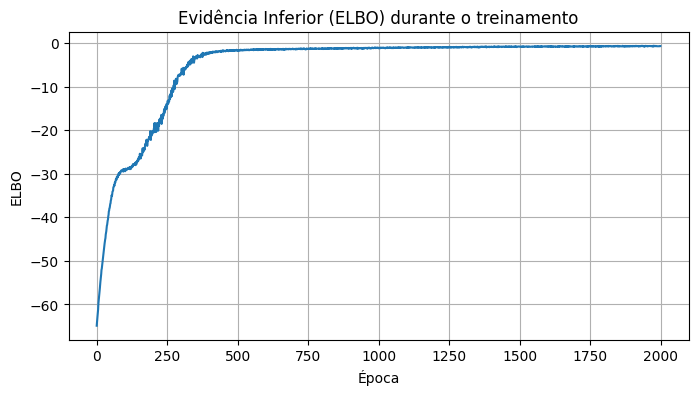

In [16]:
# Plot do ELBO ao longo das épocas (monitoramento da convergência)
plt.figure(figsize=(8, 4))
plt.plot(elbo_history)
plt.title("Evidência Inferior (ELBO) durante o treinamento")
plt.xlabel("Época")
plt.ylabel("ELBO")
plt.grid()
plt.show()

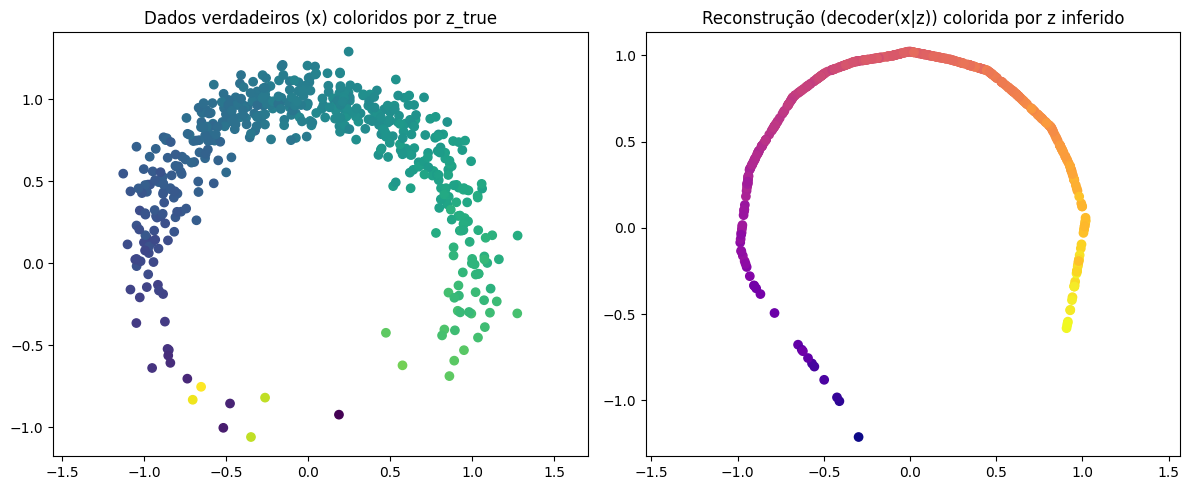

In [17]:
# Visualização comparativa: dados originais vs reconstruções
with torch.no_grad():  # Desativa cálculo de gradientes para avaliação
    x_recon, z, mu, std, _ = vae(x_data)

plt.figure(figsize=(12, 5))

# Plot dos dados originais
plt.subplot(1, 2, 1)
plt.scatter(x_data[:, 0], x_data[:, 1], c=z_true.squeeze(), cmap='viridis')
plt.title("Dados verdadeiros (x) coloridos por z_true")
plt.axis('equal')

# Plot das reconstruções
plt.subplot(1, 2, 2)
plt.scatter(x_recon[:, 0], x_recon[:, 1], c=mu.squeeze(), cmap='plasma')
plt.title("Reconstrução (decoder(x|z)) colorida por z inferido")
plt.axis('equal')

plt.tight_layout()
plt.show()

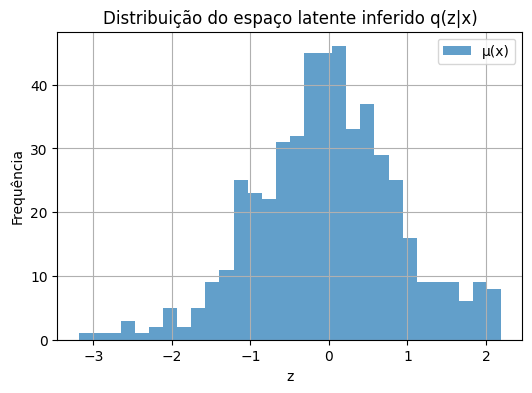

In [18]:
# Visualização da distribuição do espaço latente inferido q(z|x)
plt.figure(figsize=(6, 4))
plt.hist(mu.detach().numpy(), bins=30, alpha=0.7, label="μ(x)")
plt.title("Distribuição do espaço latente inferido q(z|x)")
plt.xlabel("z")
plt.ylabel("Frequência")
plt.legend()
plt.grid()
plt.show()

# Algoritmo EM (Expectation-Maximization)

## Definição

O algoritmo EM é um método iterativo para estimar parâmetros em modelos com variáveis latentes. Consiste em dois passos:

1. **Passo E (Expectation)**:
   - Calcula a esperança da log-verossimilhança completa em relação à distribuição posterior das variáveis latentes
   - `Q(θ|θ⁰) = E[log p(x,z|θ)|x,θ⁰]`

2. **Passo M (Maximization)**:
   - Atualiza os parâmetros maximizando a função Q
   - `θ* = argmaxₚ Q(θ|θ⁰)`

## VAE como Generalização do EM

| Componente EM       | Implementação no VAE               |
|---------------------|------------------------------------|
| Passo E             | Rede encoder (q(z|x))             |
| Passo M             | Otimização via gradiente (Adam)    |
| Posterior p(z|x)    | Aproximada por q(z|x) paramétrica  |
| Verossimilhança     | Limitada pelo ELBO                 |